In [2]:
import numpy as np
import pandas as pd

import os

In [3]:
file_loc = "transcripts_v3"

In [4]:
files = [file for file in os.listdir(file_loc) if ".txt" in file]

transcripts = []

for file in files:
    with open(os.path.join(file_loc,file), 'r') as file:
        # Read the contents of the file
        transcripts.append(file.read())
        #print(contents)

In [5]:
#extracting member transripts
def extract_member_transcript(transcript):
    transcript = transcript.split("\n\n")
    
    member_script = []
        
    for line in transcript:
        #Stripping to remove whitespaces
        line = line.strip()
        if line[:6] == "Member":
            #Appending if the line starts with Member:
            member_script.append(line[8:])
    return "\n".join(member_script)

member_transcripts = [extract_member_transcript(x) for x in transcripts]

# 

In [7]:
#Reading LLM outputs CSV
outputs_df = pd.read_csv(r"C:\Users\muham\Downloads\LLM_Outputs_v2.csv")

In [8]:
#Turing scriptsinto a DF
scripts_df = {
    "file":files,
    "script": member_transcripts
}
scripts_df = pd.DataFrame(scripts_df)
#Joning scripts to LLM outputs
outputs_df = pd.merge(outputs_df,scripts_df, on= "file")

In [9]:
#Adding classification column from sentiment scores
def classify_sentiment(row):
    if row['positive'] >= row['neutral'] and row['positive'] >= row['negative']:
        return 'positive'
    elif row['neutral'] >= row['positive'] and row['neutral'] >= row['negative']:
        return 'neutral'
    else:
        return 'negative'

# Apply the function to each row and create a new column
outputs_df['sentiment'] = outputs_df.apply(classify_sentiment, axis=1)

# Evaluating Models

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

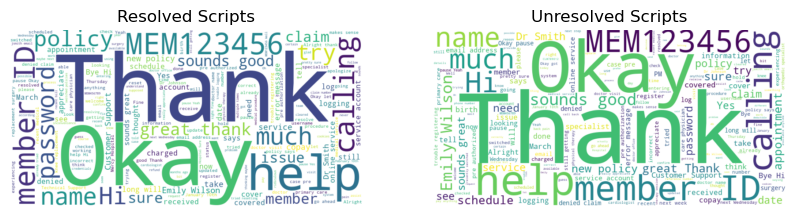

In [12]:
from wordcloud import WordCloud, STOPWORDS

# Separate resolved and unresolved scripts
resolved_scripts = outputs_df[outputs_df['resolved'] == 1]['script'].str.cat(sep=' ')
unresolved_scripts = outputs_df[outputs_df['resolved'] == 0]['script'].str.cat(sep=' ')

# Define stopwords
stopwords = set(STOPWORDS)

# Generate word clouds excluding stopwords
wordcloud_resolved = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(resolved_scripts)
wordcloud_unresolved = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(unresolved_scripts)

# Plot the word clouds
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_resolved, interpolation='bilinear')
plt.title('Resolved Scripts')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_unresolved, interpolation='bilinear')
plt.title('Unresolved Scripts')
plt.axis('off')

plt.show()


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Separate resolved and unresolved scripts
resolved_scripts = outputs_df[outputs_df['resolved'] == 1]['script']
unresolved_scripts = outputs_df[outputs_df['resolved'] == 0]['script']

# Combine the scripts into a single list
combined_scripts = resolved_scripts.tolist() + unresolved_scripts.tolist()

# Create labels for the classes
labels = ['resolved'] * len(resolved_scripts) + ['unresolved'] * len(unresolved_scripts)

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Compute the TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(combined_scripts)

# Create a DataFrame with the TF-IDF scores
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Add the labels to the DataFrame
tfidf_df['label'] = labels

# Compute the average TF-IDF scores for each word in each class
resolved_tfidf = tfidf_df[tfidf_df['label'] == 'resolved'].drop(columns=['label']).mean()
unresolved_tfidf = tfidf_df[tfidf_df['label'] == 'unresolved'].drop(columns=['label']).mean()

# Create a DataFrame with the results
tfidf_comparison_df = pd.DataFrame({'resolved': resolved_tfidf, 'unresolved': unresolved_tfidf})
tfidf_comparison_df['difference'] = tfidf_comparison_df['resolved'] - tfidf_comparison_df['unresolved']

# Sort by the absolute difference
tfidf_comparison_df = tfidf_comparison_df.reindex(tfidf_comparison_df['difference'].abs().sort_values(ascending=False).index)

# Display the top 10 words with the highest difference
print(tfidf_comparison_df.head(10))

             resolved  unresolved  difference
schedule     0.029991    0.059501   -0.029509
specialist   0.023499    0.047419   -0.023920
think        0.013131    0.035473   -0.022342
working      0.024932    0.003776    0.021156
copay        0.050695    0.031798    0.018897
appointment  0.033781    0.052531   -0.018750
available    0.009232    0.027011   -0.017779
like         0.019452    0.036112   -0.016661
wednesday    0.021140    0.037587   -0.016448
pm           0.011556    0.027846   -0.016290


In [14]:
# Separate scripts based on sentiment
positive_scripts = outputs_df[outputs_df['sentiment'] == 'positive']['script']
neutral_scripts = outputs_df[outputs_df['sentiment'] == 'neutral']['script']
negative_scripts = outputs_df[outputs_df['sentiment'] == 'negative']['script']

# Combine the scripts into a single list
combined_scripts = positive_scripts.tolist() + neutral_scripts.tolist() + negative_scripts.tolist()

# Create labels for the classes
labels = ['positive'] * len(positive_scripts) + ['neutral'] * len(neutral_scripts) + ['negative'] * len(negative_scripts)

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Compute the TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(combined_scripts)

# Create a DataFrame with the TF-IDF scores
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Add the labels to the DataFrame
tfidf_df['label'] = labels

# Compute the average TF-IDF scores for each word in each class
positive_tfidf = tfidf_df[tfidf_df['label'] == 'positive'].drop(columns=['label']).mean()
neutral_tfidf = tfidf_df[tfidf_df['label'] == 'neutral'].drop(columns=['label']).mean()
negative_tfidf = tfidf_df[tfidf_df['label'] == 'negative'].drop(columns=['label']).mean()

# Create a DataFrame with the results
tfidf_comparison_df = pd.DataFrame({
    'positive': positive_tfidf,
    'neutral': neutral_tfidf,
    'negative': negative_tfidf
})

# Compute the differences
tfidf_comparison_df['pos_vs_neutral_diff'] = tfidf_comparison_df['positive'] - tfidf_comparison_df['neutral']
tfidf_comparison_df['pos_vs_negative_diff'] = tfidf_comparison_df['positive'] - tfidf_comparison_df['negative']
tfidf_comparison_df['neutral_vs_negative_diff'] = tfidf_comparison_df['neutral'] - tfidf_comparison_df['negative']

# Sort by the absolute difference of the 'pos_vs_neutral_diff'
tfidf_comparison_df = tfidf_comparison_df.reindex(tfidf_comparison_df['pos_vs_neutral_diff'].abs().sort_values(ascending=False).index)

# Display the top 5 words with the highest difference for 'positive vs neutral'
print(tfidf_comparison_df[['positive', 'neutral', 'pos_vs_neutral_diff']].head(5))

# Sort by the absolute difference of the 'pos_vs_negative_diff'
tfidf_comparison_df = tfidf_comparison_df.reindex(tfidf_comparison_df['pos_vs_negative_diff'].abs().sort_values(ascending=False).index)

# Display the top 5 words with the highest difference for 'positive vs negative'
print(tfidf_comparison_df[['positive', 'negative', 'pos_vs_negative_diff']].head(5))

# Sort by the absolute difference of the 'neutral_vs_negative_diff'
tfidf_comparison_df = tfidf_comparison_df.reindex(tfidf_comparison_df['neutral_vs_negative_diff'].abs().sort_values(ascending=False).index)

# Display the top 5 words with the highest difference for 'neutral vs negative'
print(tfidf_comparison_df[['neutral', 'negative', 'neutral_vs_negative_diff']].head(5))


             positive   neutral  pos_vs_neutral_diff
was          0.023490  0.068080            -0.044590
an           0.062197  0.025148             0.037050
support      0.057535  0.022565             0.034970
appointment  0.061475  0.027791             0.033684
ve           0.078465  0.045872             0.032593
         positive  negative  pos_vs_negative_diff
support  0.057535  0.016318              0.041217
sighs    0.037887  0.003209              0.034678
ll       0.050408  0.016446              0.033962
ve       0.078465  0.045773              0.032692
was      0.023490  0.054303             -0.030813
           neutral  negative  neutral_vs_negative_diff
schedule  0.025457  0.046891                 -0.021434
some      0.010486  0.031021                 -0.020535
think     0.010488  0.030783                 -0.020295
the       0.105137  0.086266                  0.018871
cover     0.031142  0.012438                  0.018704


# EDA

In [16]:
from scipy.stats import mannwhitneyu

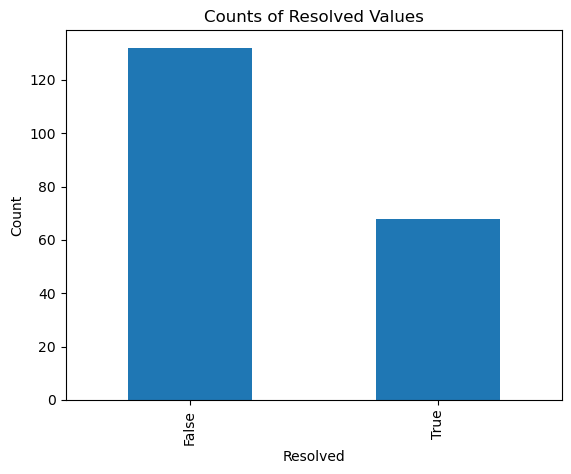

In [17]:
counts = outputs_df['resolved'].value_counts()
counts.plot(kind='bar')
plt.xlabel('Resolved')
plt.ylabel('Count')
plt.title('Counts of Resolved Values')
plt.xticks([0, 1], ['False', 'True'])
plt.show()

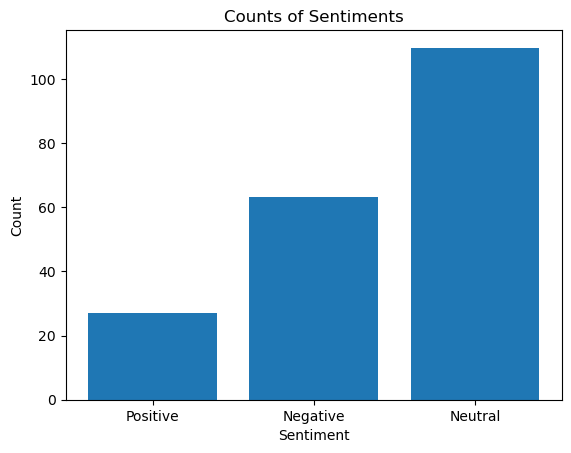

In [18]:
# Count the True values for each column
positive_count = sum(outputs_df['positive'])
negative_count = sum(outputs_df['negative'])
neutral_count = sum(outputs_df['neutral'])

# Create a bar plot
counts = [positive_count, negative_count, neutral_count]
labels = ['Positive', 'Negative', 'Neutral']

plt.bar(labels, counts)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Counts of Sentiments')
plt.show()

In [19]:
# Splitting data based on resolved
group1 = outputs_df[outputs_df['resolved'] == 1]
group2 = outputs_df[outputs_df['resolved'] == 0]

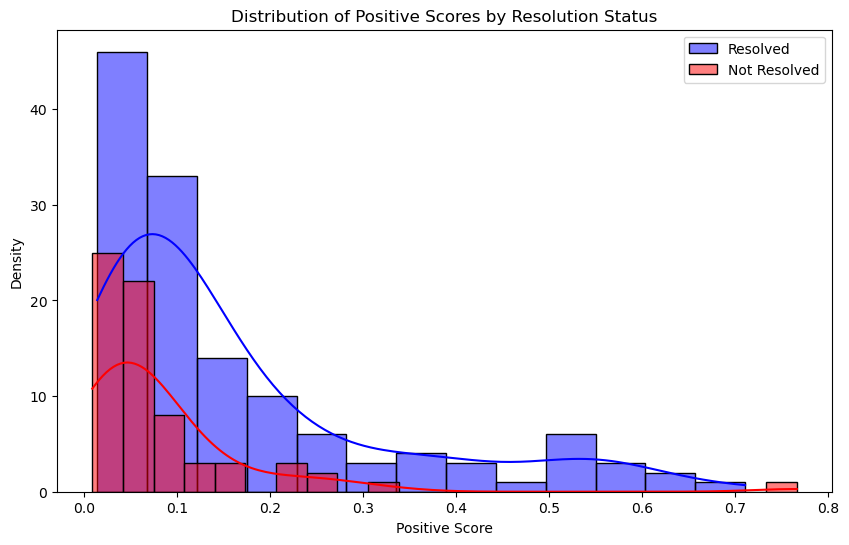

In [20]:
# Plotting the distributions
plt.figure(figsize=(10, 6))
sns.histplot(group1["positive"], color='blue', kde=True, label='Resolved')
sns.histplot(group2["positive"], color='red', kde=True, label='Not Resolved')

# Adding titles and labels
plt.title('Distribution of Positive Scores by Resolution Status')
plt.xlabel('Positive Score')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()


In [21]:
# Perform Mann-Whitney U Test
u_stat, p_value = mannwhitneyu(group1["positive"], group2["positive"])
print(f"U-statistic: {u_stat}")
print(f"P-value: {p_value}")

U-statistic: 6178.0
P-value: 1.3172557271163707e-05


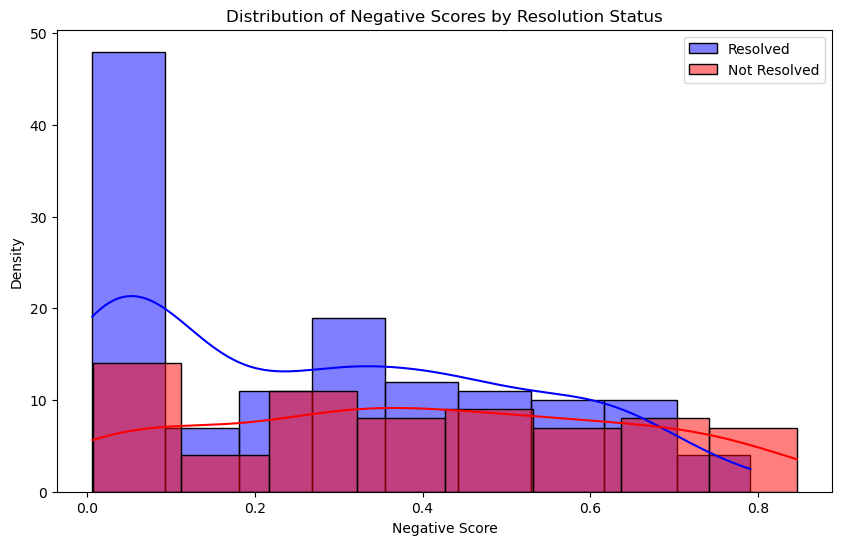

In [22]:
# Plotting the distributions
plt.figure(figsize=(10, 6))
sns.histplot(group1["negative"], color='blue', kde=True, label='Resolved')
sns.histplot(group2["negative"], color='red', kde=True, label='Not Resolved')

# Adding titles and labels
plt.title('Distribution of Negative Scores by Resolution Status')
plt.xlabel('Negative Score')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()


In [23]:
# Perform Mann-Whitney U Test
u_stat, p_value = mannwhitneyu(group1["negative"], group2["negative"])
print(f"U-statistic: {u_stat}")
print(f"P-value: {p_value}")

U-statistic: 3220.0
P-value: 0.0010797361698353235
